# BerlinMOD Example

This example uses synthetic trip data in Brussels generated by the [MobilityDB-BerlinMOD](https://github.com/MobilityDB/MobilityDB-BerlinMOD) generator to show some data manipulations available in PyMEOS.
It is divided in 5 sections, each corresponding to one MEOS example:
- [Disassembling Trips](https://libmeos.org/tutorialprograms/meos_disassemble_berlinmod/)
- [Clipping Trips to Geometries](https://libmeos.org/tutorialprograms/meos_clip_berlinmod/)
- [Tiling Trips](https://libmeos.org/tutorialprograms/meos_tile_berlinmod/)
- [Simplifying Trips](https://libmeos.org/tutorialprograms/meos_simplify_berlinmod/)
- [Temporal Aggregation of Trips](https://libmeos.org/tutorialprograms/meos_aggregate_berlinmod/)

This example uses the plotting capabilities of PyMEOS. To get the necessary dependencies for this example, you can run the following command:
```shell
pip install pymeos[plot, pandas] contextily distinctipy
```

In [2]:
from datetime import timedelta
from functools import partial

import contextily as cx
import distinctipy
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as shp
from pymeos import *
from pymeos.plotters import (
    TemporalPointSequenceSetPlotter,
    TemporalPointSequencePlotter,
)
from shapely import wkb

pymeos_initialize()

In every following section we use the data from the BerlinMOD Generator, so we will go ahead and read it.

In [3]:
trips = pd.read_csv(
    "./data/trips.csv",
    converters={
        "trip": TGeomPointSeq,
    },
)
trips.head()

vehicle         day  seq                                               trip
0        1  2020-06-01    1  [POINT(496253.84080706234 6601691.244869352)@2...
1        1  2020-06-01    2  [POINT(481241.17182724166 6588272.126511315)@2...
2        1  2020-06-02    1  [POINT(496253.84080706234 6601691.244869352)@2...
3        1  2020-06-02    2  [POINT(481241.17182724166 6588272.126511315)@2...
4        1  2020-06-03    1  [POINT(496253.84080706234 6601691.244869352)@2...

## Disassembling Trips ([MEOS Example](https://libmeos.org/tutorialprograms/meos_disassemble_berlinmod/))

In this section, we disassemble the trips into individual observations and write them in a CSV file ordered by timestamp.

First, we'll obtain every timestamp and value from the trajectory object (`TGeogPointSeq`) using the `timestamps` and `values` functions respectively

In [4]:
records = trips.drop("trip", axis=1).copy()
records["geom"] = trips["trip"].apply(lambda tr: tr.values())
records["t"] = trips["trip"].apply(lambda tr: tr.timestamps())
records.head()

vehicle         day  seq  \
0        1  2020-06-01    1   
1        1  2020-06-01    2   
2        1  2020-06-02    1   
3        1  2020-06-02    2   
4        1  2020-06-03    1   

                                                geom  \
0  [POINT (496253.84080706234 6601691.244869352),...   
1  [POINT (481241.17182724166 6588272.126511315),...   
2  [POINT (496253.84080706234 6601691.244869352),...   
3  [POINT (481241.17182724166 6588272.126511315),...   
4  [POINT (496253.84080706234 6601691.244869352),...   

                                                   t  
0  [2020-06-01 11:48:50.886000+02:00, 2020-06-01 ...  
1  [2020-06-01 18:00:27.208000+02:00, 2020-06-01 ...  
2  [2020-06-02 11:31:07.888000+02:00, 2020-06-02 ...  
3  [2020-06-02 18:47:26.738000+02:00, 2020-06-02 ...  
4  [2020-06-03 11:30:29.334000+02:00, 2020-06-03 ...

Now we "explode" the `t` and `geom` columns to get a row per record. Then, we sort the records by timestamp.

In [5]:
records = records.explode(["geom", "t"], ignore_index=True)
records = records.sort_values("t")
records.head()

vehicle         day  seq                                         geom  \
110254        8  2020-06-01    1   POINT (493442.7231019071 6595901.46838472)   
110255        8  2020-06-01    1  POINT (493443.8028284878 6595906.350412016)   
110256        8  2020-06-01    1   POINT (493444.404026218 6595909.068751807)   
110257        8  2020-06-01    1  POINT (493441.7878750556 6595913.329708636)   
110258        8  2020-06-01    1  POINT (493428.7071192439 6595934.634492779)   

                                      t  
110254 2020-06-01 10:22:51.025000+02:00  
110255 2020-06-01 10:22:52.525000+02:00  
110256 2020-06-01 10:22:54.574117+02:00  
110257 2020-06-01 10:22:55.639765+02:00  
110258 2020-06-01 10:23:00.139765+02:00

Finally, we will write it in a CSV file, encoding first the geometries as HexWKB

In [6]:
records["geom"] = records["geom"].apply(partial(wkb.dumps, hex=True))
records.head()

vehicle         day  seq                                        geom  \
110254        8  2020-06-01    1  01010000008BD374E40A1E1E41E803FA5D4F295941   
110255        8  2020-06-01    1  0101000000CEAB18360F1E1E4185266D9650295941   
110256        8  2020-06-01    1  0101000000840CB99D111E1E41FB6D664451295941   
110257        8  2020-06-01    1  0101000000F5B7C826071E1E4140F2195552295941   
110258        8  2020-06-01    1  01010000002C1117D4D21D1E419A879BA857295941   

                                      t  
110254 2020-06-01 10:22:51.025000+02:00  
110255 2020-06-01 10:22:52.525000+02:00  
110256 2020-06-01 10:22:54.574117+02:00  
110257 2020-06-01 10:22:55.639765+02:00  
110258 2020-06-01 10:23:00.139765+02:00

In [7]:
records.to_csv("./data/trip_instants.csv", index=False)

## Clipping Trips to Geometries ([MEOS Example](https://libmeos.org/tutorialprograms/meos_clip_berlinmod/))

In this section, we compute the distance traversed by the trips in the 19 [Brussels municipalities](https://en.wikipedia.org/wiki/List_of_municipalities_of_the_Brussels-Capital_Region) (communes in French)

First, we will read the files containing the information about the Brussels region and its municipalities and take a look at their shape

In [8]:
brussels = pd.read_csv(
    "./data/brussels_region.csv", converters={"geom": partial(wkb.loads, hex=True)}
)
brussels = gpd.GeoDataFrame(brussels, geometry="geom")
brussels_geom = brussels["geom"][0]
brussels

name  \
0  Région de Bruxelles-Capitale - Brussels Hoofds...   

                                                geom  
0  POLYGON ((472413.848 6589441.686, 472482.354 6...

In [9]:
communes = pd.read_csv(
    "./data/communes.csv", converters={"geom": partial(wkb.loads, hex=True)}
)
communes["color"] = [
    "#00ff00",
    "#ff00ff",
    "#007fff",
    "#ff7f00",
    "#7fbf7f",
    "#47139e",
    "#ad0414",
    "#d981f9",
    "#138014",
    "#f4fc2c",
    "#00ffff",
    "#00ff7f",
    "#c04d7c",
    "#85eaf3",
    "#85d601",
    "#fca880",
    "#0000ff",
    "#019d92",
    "#907817",
]
communes = gpd.GeoDataFrame(communes, geometry="geom")
communes

id                                           name  population  \
0    1                                     Anderlecht      118241   
1    2                           Auderghem - Oudergem       33313   
2    3    Berchem-Sainte-Agathe - Sint-Agatha-Berchem       24701   
3    4                                      Etterbeek      176545   
4    5                                          Evere       47414   
5    6                                 Forest - Vorst       40394   
6    7                                      Ganshoren       55746   
7    8                               Ixelles - Elsene       24596   
8    9                                          Jette       86244   
9   10                                     Koekelberg       51933   
10  11     Molenbeek-Saint-Jean - Sint-Jans-Molenbeek       21609   
11  12                     Saint-Gilles - Sint-Gillis       96629   
12  13    Saint-Josse-ten-Noode - Sint-Joost-ten-Node       50471   
13  14                        Schaerbeek - Schaarbeek       27115   
14  15                                  Uccle - Ukkel      133042   
15  16              Ville de Bruxelles - Stad Brussel       82307   
16  17      Watermael-Boitsfort - Watermaal-Bosvoorde       24871   
17  18  Woluwe-Saint-Lambert - Sint-Lambrechts-Woluwe       55216   
18  19      Woluwe-Saint-Pierre - Sint-Pieters-Woluwe       41217   

                                                 geom    color  
0   POLYGON ((476959.746 6593981.357, 476965.401 6...  #00ff00  
1   POLYGON ((497620.844 6584185.646, 497856.652 6...  #ff00ff  
2   POLYGON ((477788.720 6599192.996, 477782.631 6...  #007fff  
3   POLYGON ((489804.602 6593678.230, 489685.067 6...  #ff7f00  
4   POLYGON ((492771.667 6597070.173, 492633.519 6...  #7fbf7f  
5   POLYGON ((479909.268 6585570.952, 479881.003 6...  #47139e  
6   POLYGON ((478477.209 6600450.089, 478499.863 6...  #ad0414  
7   MULTIPOLYGON (((487496.626 6592340.790, 487544...  #d981f9  
8   POLYGON ((481479.217 6597749.534, 481526.350 6...  #138014  
9   POLYGON ((480236.024 6597825.520, 480178.160 6...  #f4fc2c  
10  POLYGON ((477542.960 6595837.350, 477533.621 6...  #00ffff  
11  POLYGON ((483153.140 6593066.827, 483122.204 6...  #00ff7f  
12  POLYGON ((485033.738 6596581.156, 484882.700 6...  #c04d7c  
13  POLYGON ((488501.707 6600305.815, 488394.028 6...  #85eaf3  
14  POLYGON ((486268.683 6588562.809, 486253.744 6...  #85d601  
15  POLYGON ((483153.140 6593066.827, 483186.758 6...  #fca880  
16  POLYGON ((491240.935 6581131.551, 491340.822 6...  #0000ff  
17  POLYGON ((496682.744 6594589.884, 496653.033 6...  #019d92  
18  POLYGON ((496135.453 6589271.827, 496258.928 6...  #907817

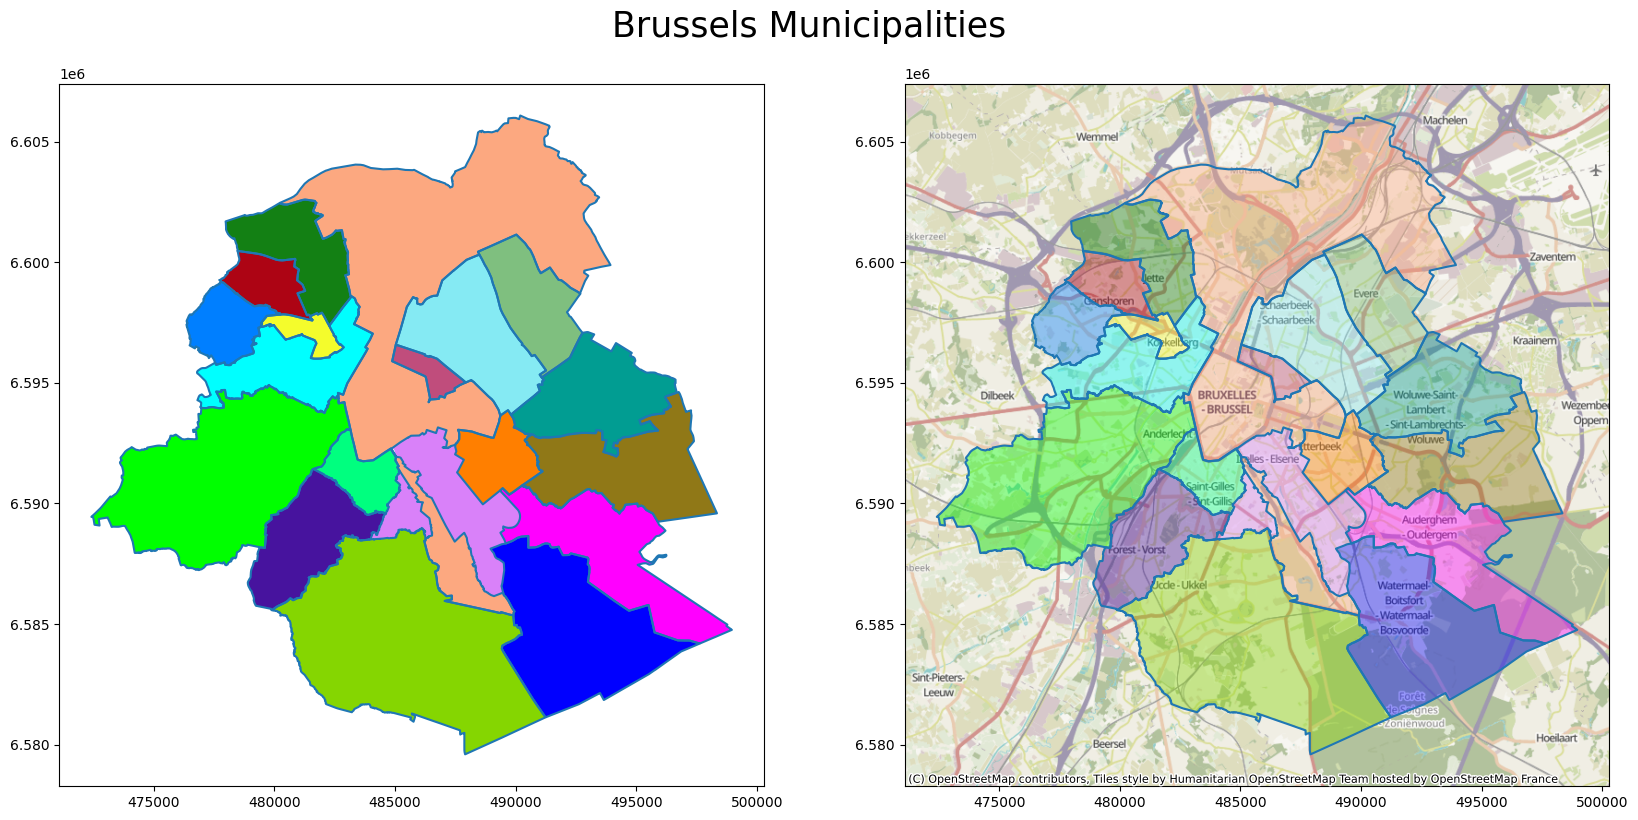

In [10]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))
communes.plot(color=communes["color"], ax=axes[0])
communes.exterior.plot(ax=axes[0])
communes.plot(color=communes["color"], ax=axes[1], alpha=0.4)
communes.exterior.plot(ax=axes[1])
cx.add_basemap(axes[1])
_ = plt.suptitle("Brussels Municipalities", size=25, y=0.92)

Now, let's take a look at the BerlinMOD trajectories plotted over Brussels

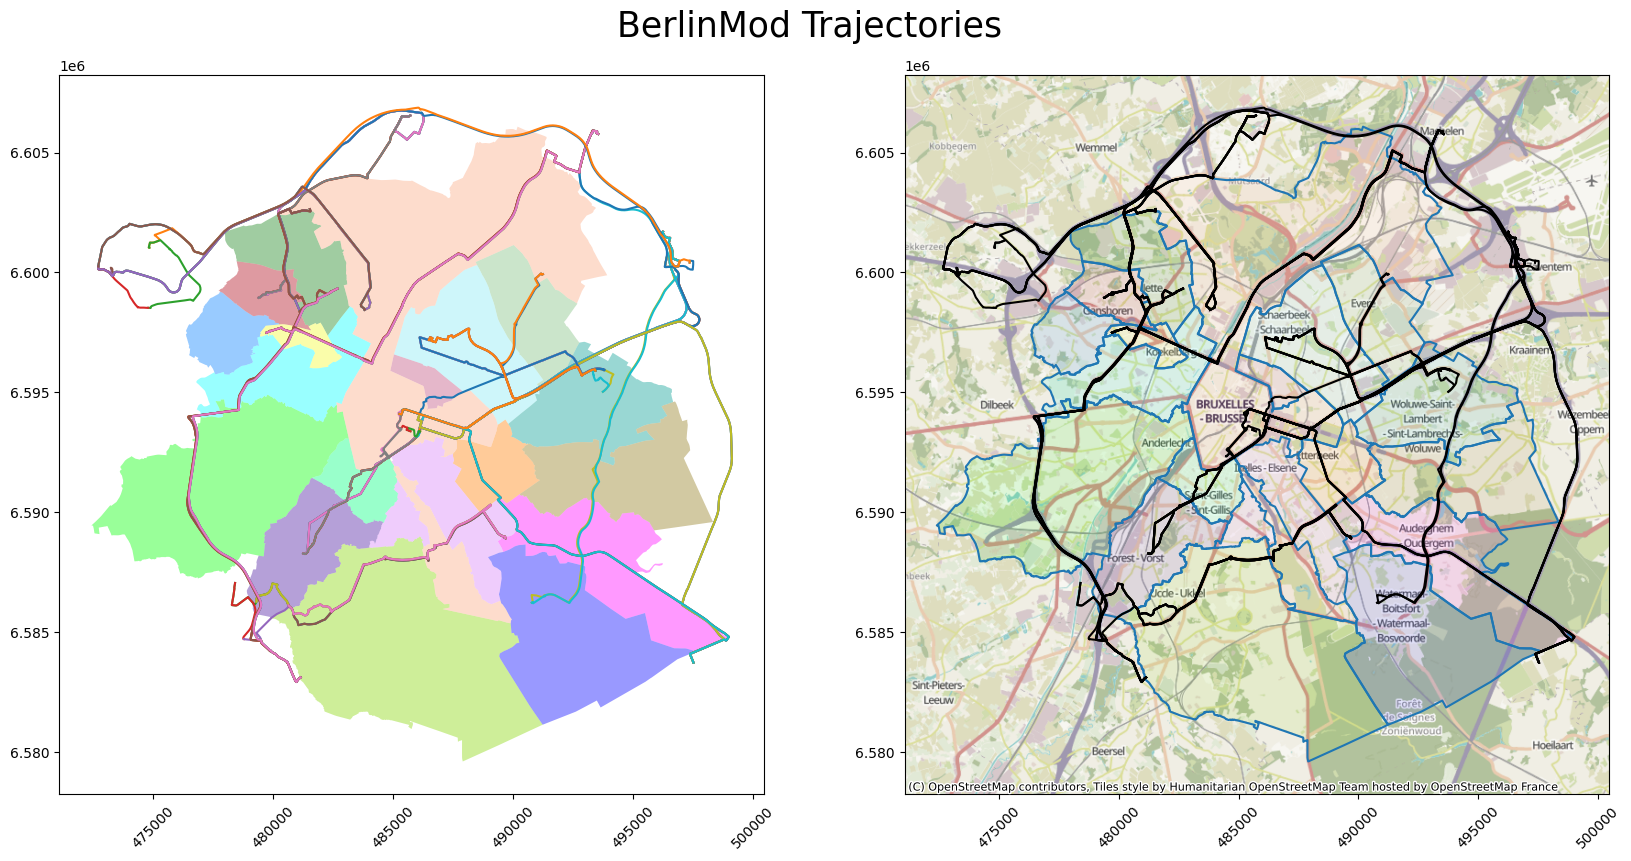

In [11]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))
communes.plot(color=communes["color"], ax=axes[0], alpha=0.4)

TemporalPointSequencePlotter.plot_sequences_xy(
    trips["trip"], axes=axes[0], show_markers=False, show_grid=False
)

communes.plot(color=communes["color"], ax=axes[1], alpha=0.1)
communes.exterior.plot(ax=axes[1])
TemporalPointSequencePlotter.plot_sequences_xy(
    trips["trip"], axes=axes[1], color="black", show_markers=False, show_grid=False
)
cx.add_basemap(axes[1])

_ = plt.suptitle("BerlinMod Trajectories", size=25, y=0.92)

First, let's split the trajectories into sections inside and outside of Brussels

In [12]:
brussels_inout_trajectories = trips.copy()
brussels_inout_trajectories["inside"] = brussels_inout_trajectories["trip"].apply(
    lambda tr: tr.at(brussels_geom)
)
brussels_inout_trajectories["outside"] = brussels_inout_trajectories["trip"].apply(
    lambda tr: tr.minus(brussels_geom)
)
brussels_inout_trajectories.head()

vehicle         day  seq  \
0        1  2020-06-01    1   
1        1  2020-06-01    2   
2        1  2020-06-02    1   
3        1  2020-06-02    2   
4        1  2020-06-03    1   

                                                trip  \
0  [POINT(496253.84080706234 6601691.244869352)@2...   
1  [POINT(481241.17182724166 6588272.126511315)@2...   
2  [POINT(496253.84080706234 6601691.244869352)@2...   
3  [POINT(481241.17182724166 6588272.126511315)@2...   
4  [POINT(496253.84080706234 6601691.244869352)@2...   

                                              inside  \
0  {[POINT(493452.04564533016 6596592.507628961)@...   
1  {[POINT(481241.17182724166 6588272.126511315)@...   
2  {[POINT(493452.04567213746 6596592.507642428)@...   
3  {[POINT(481241.17182724166 6588272.126511315)@...   
4  {[POINT(493452.04567213746 6596592.507642428)@...   

                                             outside  
0  {[POINT(496253.84080706234 6601691.244869352)@...  
1  {(POINT(493488.118266309 6596572.0201423885)@2...  
2  {[POINT(496253.84080706234 6601691.244869352)@...  
3  {(POINT(493488.118266309 6596572.0201423885)@2...  
4  {[POINT(496253.84080706234 6601691.244869352)@...

Let's see this split in a plot

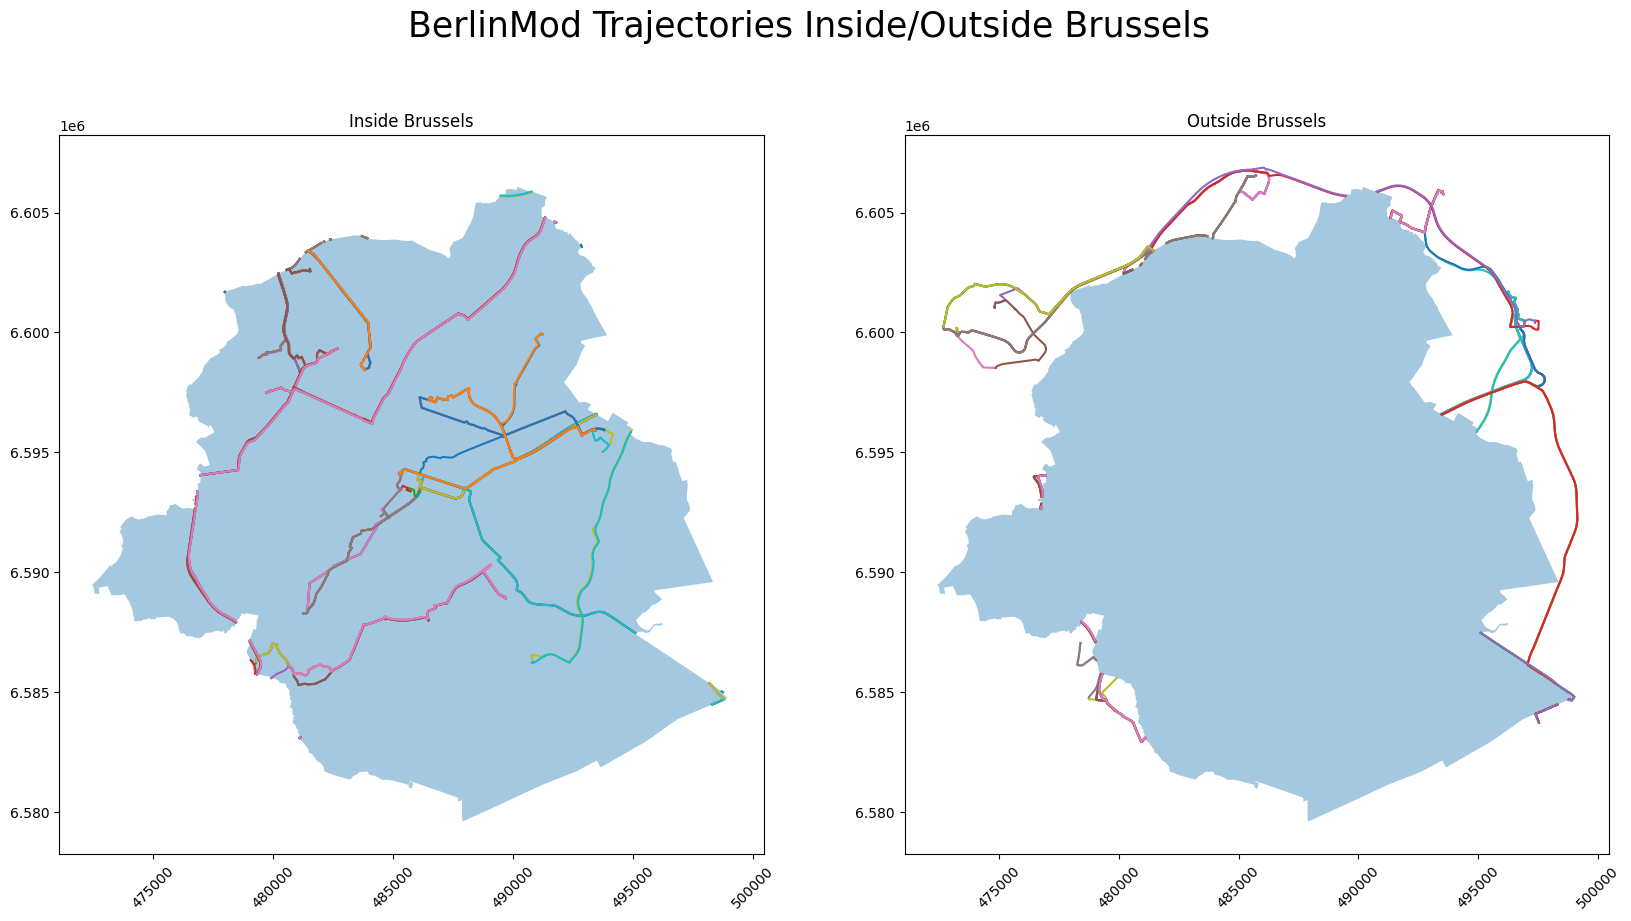

In [13]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].set_title("Inside Brussels")
brussels.plot(ax=axes[0], alpha=0.4)
for traj in brussels_inout_trajectories["inside"].dropna():
    if isinstance(traj, TGeomPointSeq):
        TemporalPointSequencePlotter.plot_xy(
            traj, axes=axes[0], show_markers=False, show_grid=False
        )
    else:
        TemporalPointSequenceSetPlotter.plot_xy(
            traj, axes=axes[0], show_markers=False, show_grid=False
        )

axes[1].set_title("Outside Brussels")
brussels.plot(ax=axes[1], alpha=0.4)
for traj in brussels_inout_trajectories["outside"].dropna():
    if isinstance(traj, TGeomPointSeq):
        TemporalPointSequencePlotter.plot_xy(
            traj, axes=axes[1], show_markers=False, show_grid=False
        )
    else:
        TemporalPointSequenceSetPlotter.plot_xy(
            traj, axes=axes[1], show_markers=False, show_grid=False
        )

axes[0].set_xlim(
    min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]),
    max(axes[0].get_xlim()[1], axes[1].get_xlim()[1]),
)
axes[0].set_ylim(
    min(axes[0].get_ylim()[0], axes[1].get_ylim()[0]),
    max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]),
)

_ = plt.suptitle("BerlinMod Trajectories Inside/Outside Brussels", size=25)

Now we will compute the trajectory and distance each trip traverses in each municipality

In [14]:
commune_trajectories = trips.copy()
for _, row in communes.iterrows():
    commune_trajectories[f'{row["name"]}-trajectory'] = commune_trajectories[
        "trip"
    ].apply(lambda tr: tr.at(row["geom"]))
    commune_trajectories[f'{row["name"]}-distance'] = commune_trajectories[
        f'{row["name"]}-trajectory'
    ].apply(lambda tr: tr.length() if tr else 0)
commune_trajectories.head()

vehicle         day  seq  \
0        1  2020-06-01    1   
1        1  2020-06-01    2   
2        1  2020-06-02    1   
3        1  2020-06-02    2   
4        1  2020-06-03    1   

                                                trip Anderlecht-trajectory  \
0  [POINT(496253.84080706234 6601691.244869352)@2...                  None   
1  [POINT(481241.17182724166 6588272.126511315)@2...                  None   
2  [POINT(496253.84080706234 6601691.244869352)@2...                  None   
3  [POINT(481241.17182724166 6588272.126511315)@2...                  None   
4  [POINT(496253.84080706234 6601691.244869352)@2...                  None   

   Anderlecht-distance Auderghem - Oudergem-trajectory  \
0                  0.0                            None   
1                  0.0                            None   
2                  0.0                            None   
3                  0.0                            None   
4                  0.0                            None   

   Auderghem - Oudergem-distance  \
0                            0.0   
1                            0.0   
2                            0.0   
3                            0.0   
4                            0.0   

  Berchem-Sainte-Agathe - Sint-Agatha-Berchem-trajectory  \
0                                               None       
1                                               None       
2                                               None       
3                                               None       
4                                               None       

   Berchem-Sainte-Agathe - Sint-Agatha-Berchem-distance  ...  \
0                                                  0     ...   
1                                                  0     ...   
2                                                  0     ...   
3                                                  0     ...   
4                                                  0     ...   

  Uccle - Ukkel-trajectory  Uccle - Ukkel-distance  \
0                     None                     0.0   
1                     None                     0.0   
2                     None                     0.0   
3                     None                     0.0   
4                     None                     0.0   

        Ville de Bruxelles - Stad Brussel-trajectory  \
0  {[POINT(489089.14461377583 6594225.227862967)@...   
1  {[POINT(484373.02614611824 6591974.073148593)@...   
2  {[POINT(489089.14461377583 6594225.227862967)@...   
3  {[POINT(484373.02614611824 6591974.073148593)@...   
4  {[POINT(489089.14461377583 6594225.227862967)@...   

   Ville de Bruxelles - Stad Brussel-distance  \
0                                 6238.532446   
1                                 5890.625638   
2                                 6238.532450   
3                                 5890.625638   
4                                 6238.532450   

  Watermael-Boitsfort - Watermaal-Bosvoorde-trajectory  \
0                                               None     
1                                               None     
2                                               None     
3                                               None     
4                                               None     

   Watermael-Boitsfort - Watermaal-Bosvoorde-distance  \
0                                                0.0    
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                                                0.0    

  Woluwe-Saint-Lambert - Sint-Lambrechts-Woluwe-trajectory  \
0  {[POINT(493452.04564533016 6596592.507628961)@...         
1  {[POINT(491131.62956994347 6595158.952745219)@...         
2  {[POINT(493452.04567213746 6596592.507642428)@...         
3  {[POINT(491131.62956994347 6595158.952745219)@...         
4  {[POINT(493452.04567213746 6596592.507642428)@...         

   Woluwe-Sai

In [15]:
distances = commune_trajectories[
    ["vehicle", "day", "seq", *(f"{commune}-distance" for commune in communes["name"])]
]
distances.head()

vehicle         day  seq  Anderlecht-distance  \
0        1  2020-06-01    1                  0.0   
1        1  2020-06-01    2                  0.0   
2        1  2020-06-02    1                  0.0   
3        1  2020-06-02    2                  0.0   
4        1  2020-06-03    1                  0.0   

   Auderghem - Oudergem-distance  \
0                            0.0   
1                            0.0   
2                            0.0   
3                            0.0   
4                            0.0   

   Berchem-Sainte-Agathe - Sint-Agatha-Berchem-distance  Etterbeek-distance  \
0                                                  0                    0.0   
1                                                  0                    0.0   
2                                                  0                    0.0   
3                                                  0                    0.0   
4                                                  0                    0.0   

   Evere-distance  Forest - Vorst-distance  Ganshoren-distance  ...  \
0             0.0              3208.550776                 0.0  ...   
1             0.0              3088.180926                 0.0  ...   
2             0.0              3208.550776                 0.0  ...   
3             0.0              3088.180930                 0.0  ...   
4             0.0              3208.550776                 0.0  ...   

   Koekelberg-distance  Molenbeek-Saint-Jean - Sint-Jans-Molenbeek-distance  \
0                  0.0                                                0.0     
1                  0.0                                                0.0     
2                  0.0                                                0.0     
3                  0.0                                                0.0     
4                  0.0                                                0.0     

   Saint-Gilles - Sint-Gillis-distance  \
0                          2082.592245   
1                          2438.565180   
2                          2082.592241   
3                          2438.565176   
4                          2082.592241   

   Saint-Josse-ten-Noode - Sint-Joost-ten-Node-distance  \
0                                                0.0      
1                                                0.0      
2                                                0.0      
3                                                0.0      
4                                                0.0      

   Schaerbeek - Schaarbeek-distance  Uccle - Ukkel-distance  \
0                       2241.087203                     0.0   
1                       2254.134586                     0.0   
2                       2241.087203                     0.0   
3                       2254.134586                     0.0   
4                       2241.087203                     0.0   

   Ville de Bruxelles - Stad Brussel-distance  \
0                                 6238.532446   
1                                 5890.625638   
2                                 6238.532450   
3                                 5890.625638   
4                                 6238.532450   

   Watermael-Boitsfort - Watermaal-Bosvoorde-distance  \
0                                                0.0    
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                                                0.0    

   Woluwe-Saint-Lambert - Sint-Lambrechts-Woluwe-distance  \
0                                        2743.319101        
1                                        2753.083663        
2                                        2743.319131        
3                                        2753.083663        
4                                        2743.319131        

   Woluwe-Saint-Pierre - Sint-Pieters-Woluwe-distance  
0                                               

Finally, let's see the visualization of the trajectories split by commune

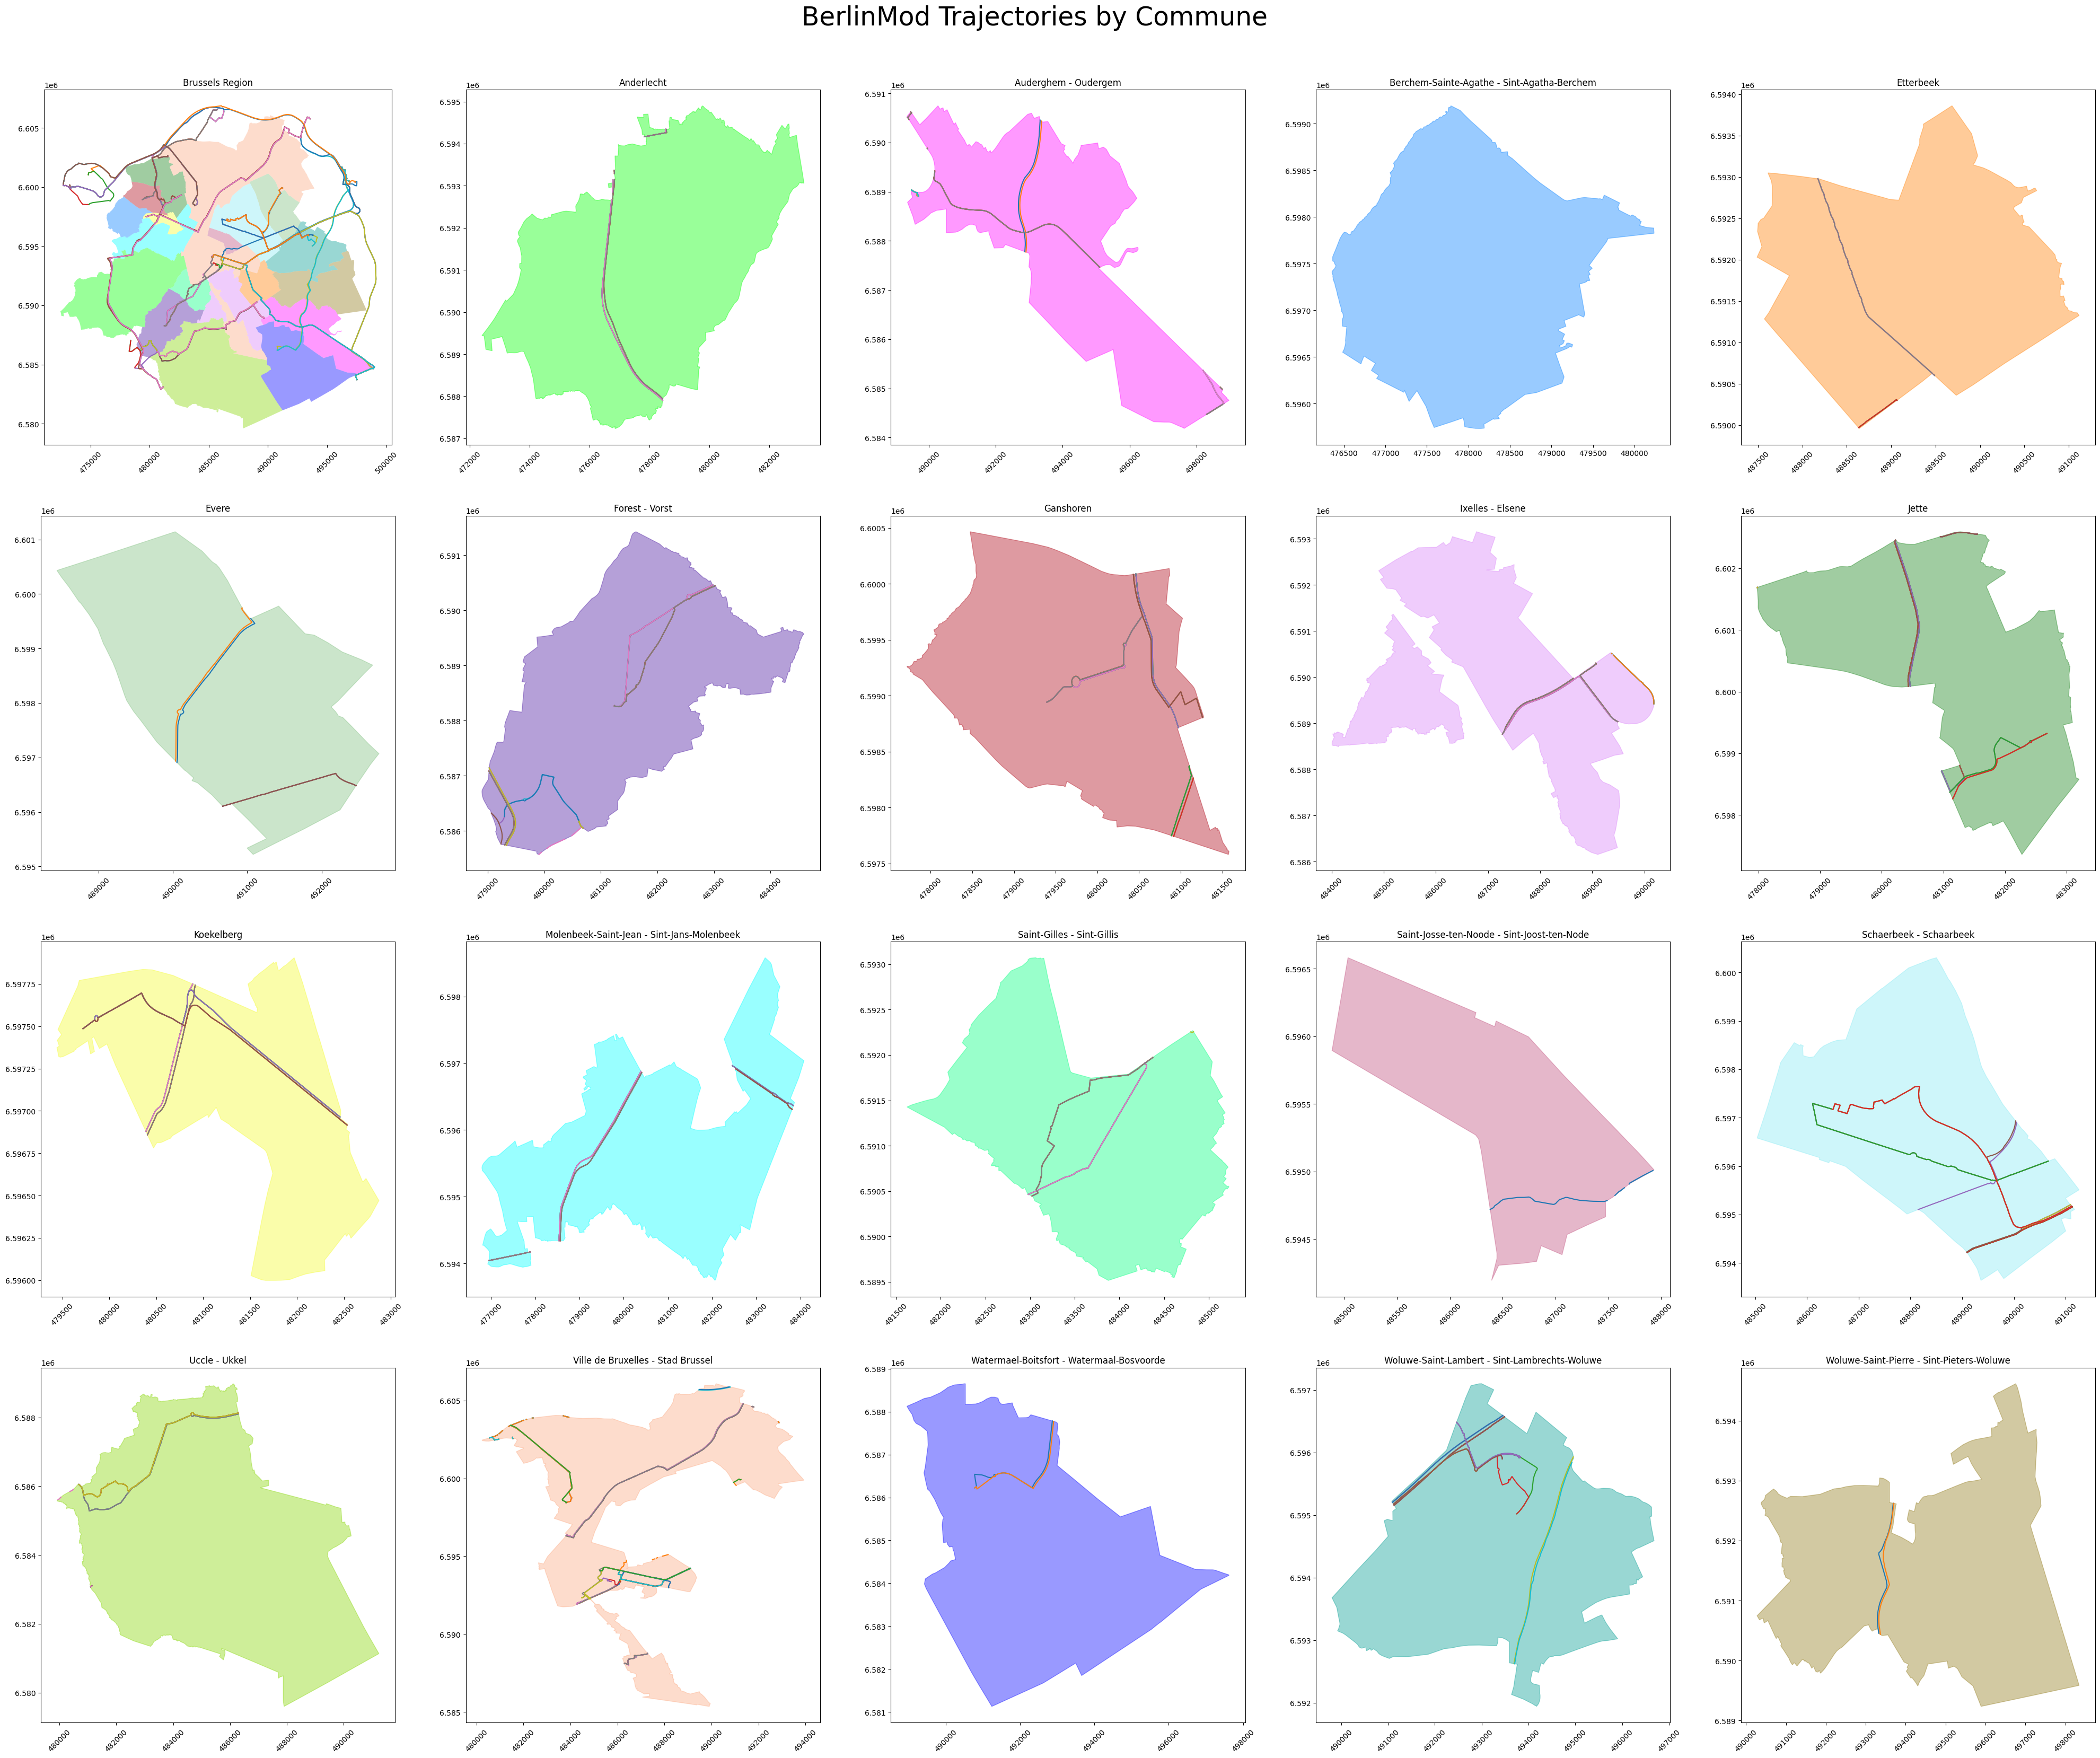

In [16]:
_, axes = plt.subplots(4, 5, figsize=(50, 40))

axes[0][0].set_title("Brussels Region")
communes.plot(color=communes["color"], ax=axes[0][0], alpha=0.4)
TemporalPointSequencePlotter.plot_sequences_xy(
    trips["trip"], axes=axes[0][0], show_markers=False, show_grid=False
)

for i, commune in communes.iterrows():
    ax = axes[(i + 1) // 5][(i + 1) % 5]
    ax.set_title(commune["name"])
    # Plot commune
    if isinstance(commune["geom"], shp.Polygon):
        ax.fill(*commune["geom"].exterior.xy, color=commune["color"], alpha=0.4)
    else:
        for g in commune["geom"].geoms:
            ax.fill(*g.exterior.xy, color=commune["color"], alpha=0.4)
    # Plot trajectories
    trajs = commune_trajectories[f'{commune["name"]}-trajectory'].dropna()
    for traj in trajs:
        TemporalPointSequenceSetPlotter.plot_xy(
            traj, axes=ax, show_markers=False, show_grid=False
        )

_ = plt.suptitle("BerlinMod Trajectories by Commune", size=35, y=0.92)

## Simplifying Trips ([MEOS Example](https://libmeos.org/tutorialprograms/meos_simplify_berlinmod/))

In this section, we will simplify the trajectories with two different methods, namely Douglas-Peucker (DP) and Syncronized Euclidean Distance (SED, aka Top-Down Time Ratio simplification), and compare the simplifications.

First, we'll choose a distance tolerance to use in the simplification

In [17]:
tolerance = 20

Now, we'll compute both simplifications with the `simplify_douglas_peucker` method (using the `synchronized` parameter to chose between DP or SED)

In [18]:
simplifications = trips.copy()
simplifications["dp"] = simplifications["trip"].apply(
    lambda tr: tr.simplify_douglas_peucker(tolerance)
)
simplifications["sed"] = simplifications["trip"].apply(
    lambda tr: tr.simplify_douglas_peucker(tolerance, synchronized=True)
)
simplifications.head()

vehicle         day  seq  \
0        1  2020-06-01    1   
1        1  2020-06-01    2   
2        1  2020-06-02    1   
3        1  2020-06-02    2   
4        1  2020-06-03    1   

                                                trip  \
0  [POINT(496253.84080706234 6601691.244869352)@2...   
1  [POINT(481241.17182724166 6588272.126511315)@2...   
2  [POINT(496253.84080706234 6601691.244869352)@2...   
3  [POINT(481241.17182724166 6588272.126511315)@2...   
4  [POINT(496253.84080706234 6601691.244869352)@2...   

                                                  dp  \
0  [POINT(496253.84080706234 6601691.244869352)@2...   
1  [POINT(481241.17182724166 6588272.126511315)@2...   
2  [POINT(496253.84080706234 6601691.244869352)@2...   
3  [POINT(481241.17182724166 6588272.126511315)@2...   
4  [POINT(496253.84080706234 6601691.244869352)@2...   

                                                 sed  
0  [POINT(496253.84080706234 6601691.244869352)@2...  
1  [POINT(481241.17182724166 6588272.126511315)@2...  
2  [POINT(496253.84080706234 6601691.244869352)@2...  
3  [POINT(481241.17182724166 6588272.126511315)@2...  
4  [POINT(496253.84080706234 6601691.244869352)@2...

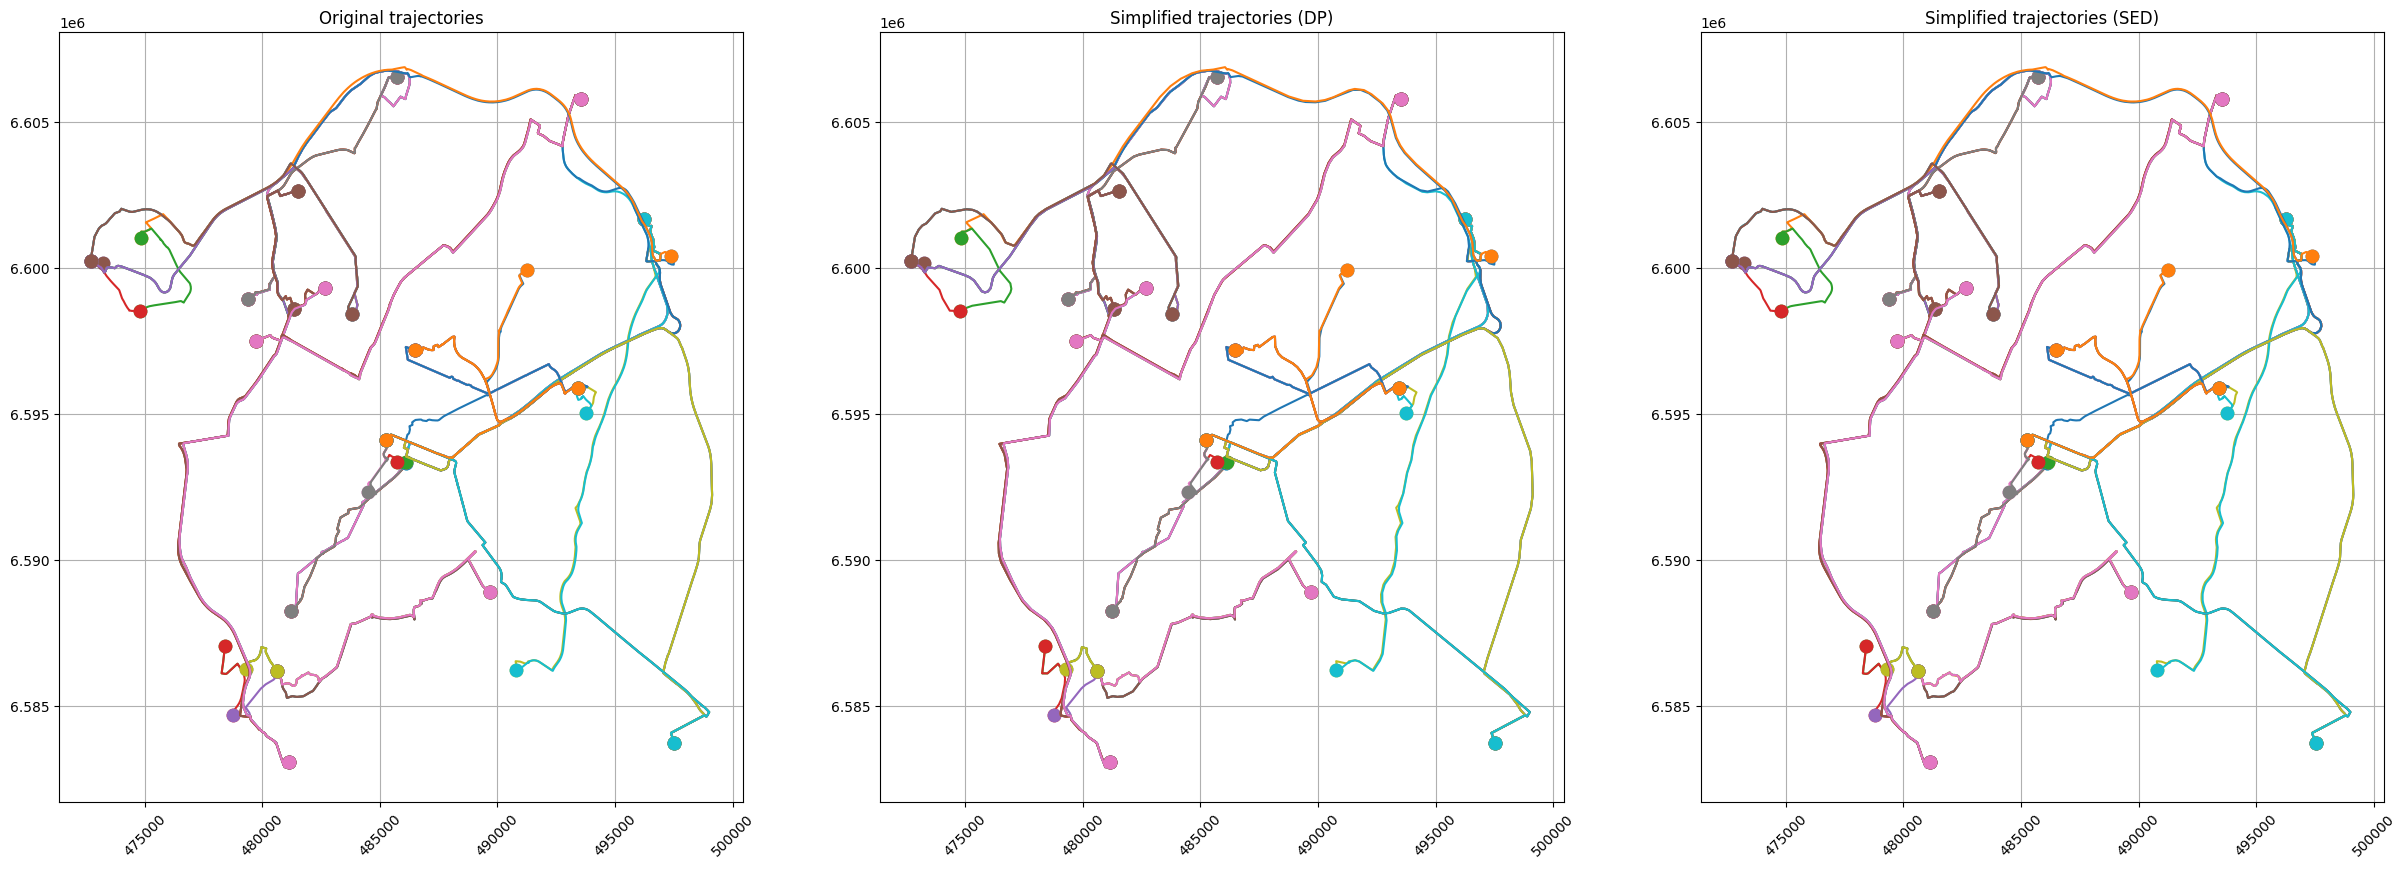

In [19]:
_, axes = plt.subplots(1, 3, figsize=(30, 10))
for _, trip in simplifications.iterrows():
    trip["trip"].plot(axes=axes[0])
    trip["dp"].plot(axes=axes[1])
    trip["sed"].plot(axes=axes[2])
axes[0].set_title("Original trajectories")
axes[1].set_title("Simplified trajectories (DP)")
axes[2].set_title("Simplified trajectories (SED)")
plt.show()

Let's focus on only one trajectory to see the simplification more clearly

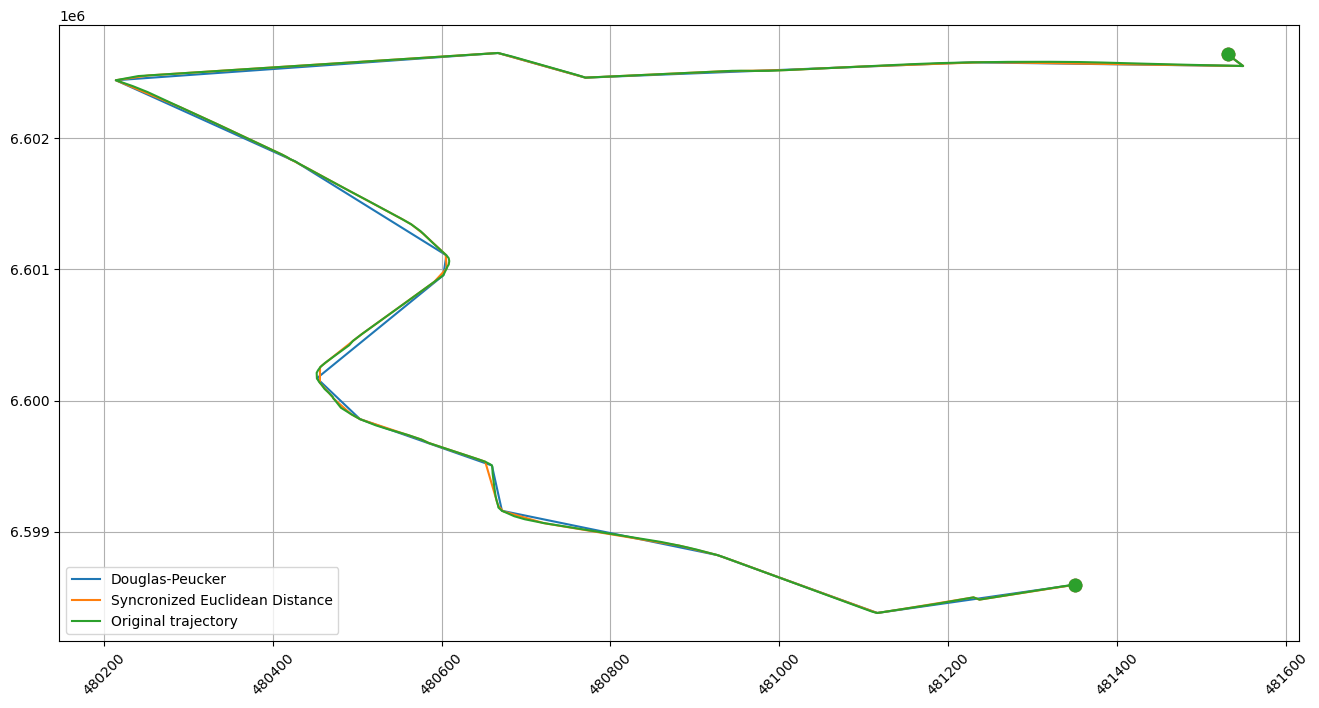

In [20]:
trip_example = simplifications.iloc[20]
fig, ax = plt.subplots(figsize=(16, 8))
trip_example["dp"].plot(label="Douglas-Peucker")
trip_example["sed"].plot(label="Syncronized Euclidean Distance")
trip_example["trip"].plot(label="Original trajectory")
plt.legend()
plt.show()

Now, let's see the difference in points in each trajectory with their simplifications

In [21]:
distances = simplifications[["vehicle", "day", "seq"]].copy()
distances["trip"] = simplifications["trip"].apply(lambda tr: tr.num_instants())
distances["dp"] = simplifications["dp"].apply(lambda tr: tr.num_instants())
distances["sed"] = simplifications["sed"].apply(lambda tr: tr.num_instants())
distances["dp-delta"] = distances["trip"] - distances["dp"]
distances["sed-delta"] = distances["trip"] - distances["sed"]
distances["dp-%"] = distances["dp"] * 100 / distances["trip"]
distances["sed-%"] = distances["sed"] * 100 / distances["trip"]
distances.head()

vehicle         day  seq  trip  dp  sed  dp-delta  sed-delta      dp-%  \
0        1  2020-06-01    1  2103  48  212      2055       1891  2.282454   
1        1  2020-06-01    2  2326  65  232      2261       2094  2.794497   
2        1  2020-06-02    1  2110  48  207      2062       1903  2.274882   
3        1  2020-06-02    2  2308  65  235      2243       2073  2.816291   
4        1  2020-06-03    1  2071  48  190      2023       1881  2.317721   

       sed-%  
0  10.080837  
1   9.974205  
2   9.810427  
3  10.181976  
4   9.174312

We can see in the following table that the DP-simplified trips contain only a 3% of the original points in average, and that the SED-simplified ones around a 10%.

In [22]:
distances[["dp-delta", "dp-%", "sed-delta", "sed-%"]].describe()

dp-delta       dp-%    sed-delta      sed-%
count    96.000000  96.000000    96.000000  96.000000
mean   1425.489583   2.686471  1315.750000   9.568915
std     718.930726   1.068704   649.342437   1.514393
min      98.000000   1.731844    91.000000   7.011070
25%     923.500000   1.999928   875.250000   8.475305
50%    1616.000000   2.367245  1471.500000   9.281897
75%    2056.750000   2.859347  1894.000000  10.622931
max    3333.000000   7.547170  2990.000000  14.150943

## Temporal Aggregation of Trips ([MEOS Example](https://libmeos.org/tutorialprograms/meos_aggregate_berlinmod/))

In this section we will aggregate the trips to calculate the extent (the spatiotemporal bounding box) and the temporal count (the evolution on time of the number of vehicles travelling).
PyMEOS offers two APIs for aggregating: bulk and streaming.

### Bulk aggregation
If you have all the elements to aggregate in memory, you can use the bulk aggregation to perform it in a single call.
To do so, use the `aggregate` methods of the aggregator classes.

Now, let's compute the extent and the temporal count using the `TemporalPointExtentAggregator` and `TemporalPeriodCountAggregator` respectively

In [23]:
extent_bulk = TemporalPointExtentAggregator.aggregate(trips["trip"])
tcount_bulk = TemporalPeriodCountAggregator.aggregate(trips["trip"])

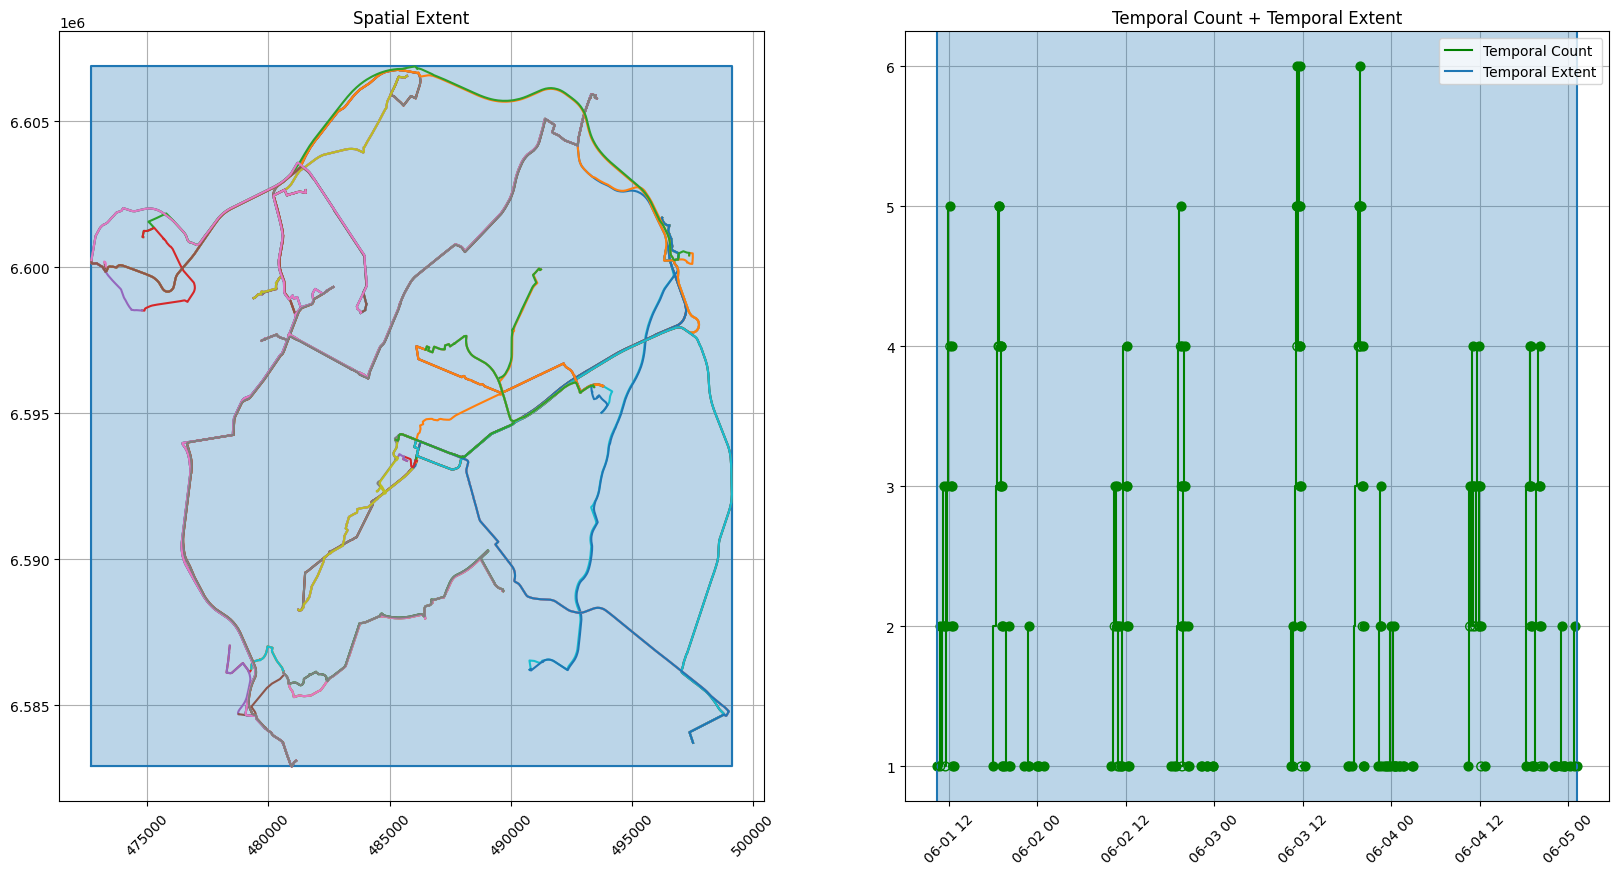

In [24]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))

extent_bulk.plot_xy(axes=axes[0], label="Spatial Extent")
for _, trip in trips.iterrows():
    trip["trip"].plot(axes=axes[0], show_markers=False)
axes[0].set_title("Spatial Extent")

tcount_bulk.plot(axes=axes[1], label="Temporal Count", color="g")
extent_bulk.to_period().plot(axes=axes[1], label="Temporal Extent")
axes[1].set_title("Temporal Count + Temporal Extent")

plt.legend()
plt.show()

Let's take the extent of only a few hours to see clearly the aggregations

In [25]:
day_trips = (
    trips["trip"]
    .apply(lambda tr: tr.at(Period("[2020-06-01 08:00:00, 2020-06-01 12:00:00]")))
    .dropna()
)
day_extent = TemporalPointExtentAggregator.aggregate(day_trips)
day_tcount = TemporalPeriodCountAggregator.aggregate(day_trips)

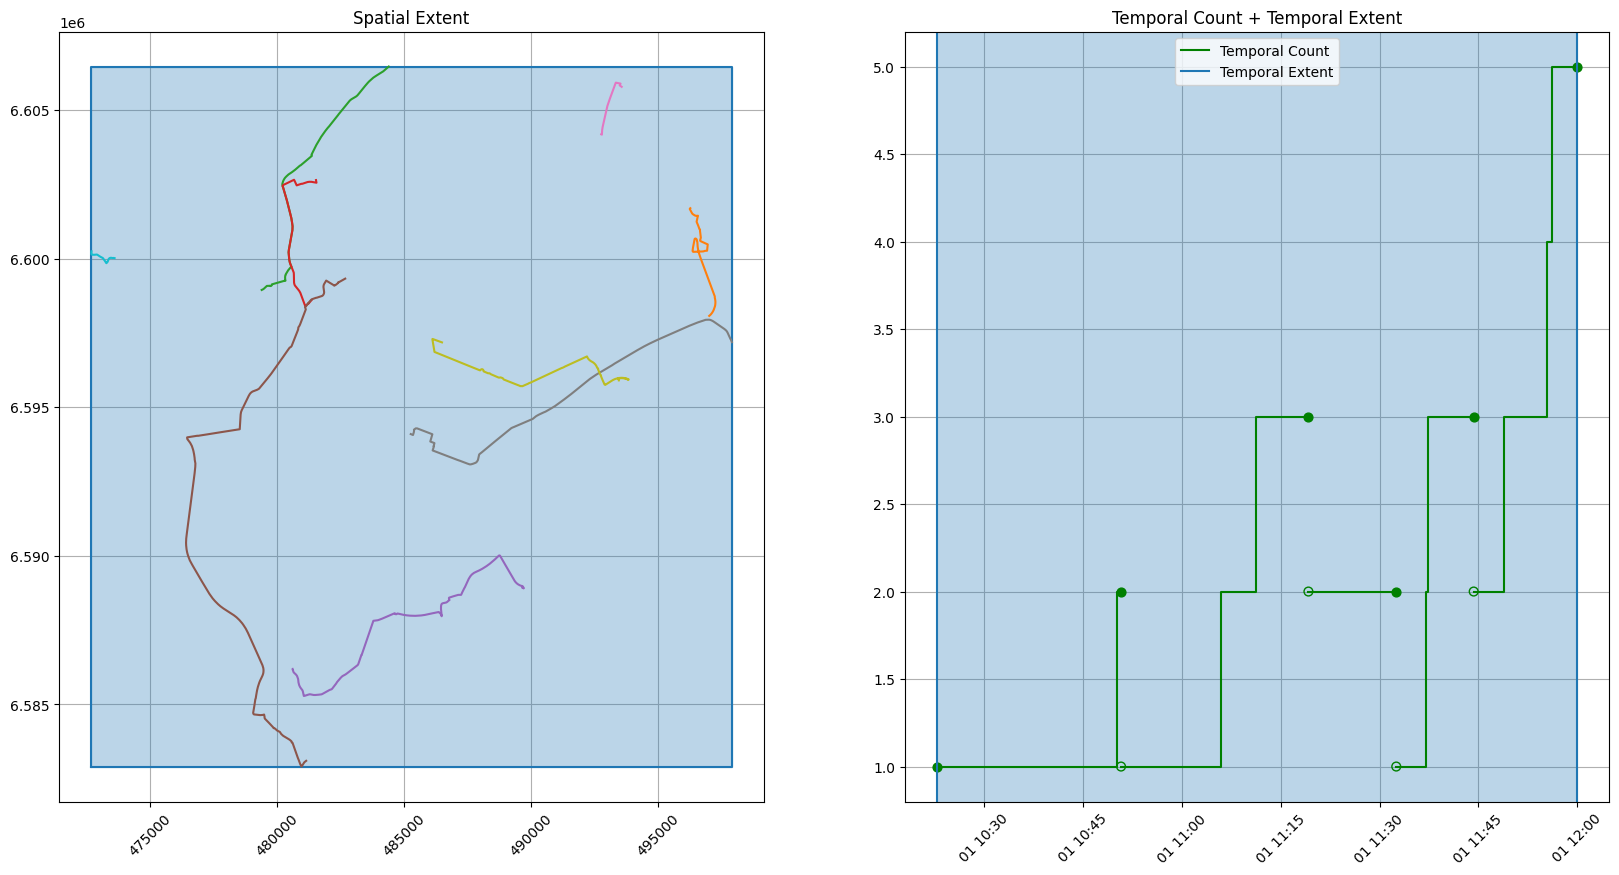

In [26]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))

day_extent.plot_xy(axes=axes[0], label="Spatial Extent")
for trip in day_trips:
    trip.plot(axes=axes[0], show_markers=False)
axes[0].set_title("Spatial Extent")

day_tcount.plot(axes=axes[1], label="Temporal Count", color="g")
day_extent.to_period().plot(axes=axes[1], label="Temporal Extent")
axes[1].set_title("Temporal Count + Temporal Extent")

plt.legend()
plt.show()

### Streaming Aggregation

There will be cases when you don't have all the elements in memory at once, for example, maybe there are too many and memory is limited, or you are receiving them on real time, and you want to aggregate as they arrive.
In those cases, you can use the streaming aggregation to perform the aggregation in steps.
To do so, use the `start_aggregation` method of the aggregator class, and then use the object returned to perform the aggregation using the `add` and `aggregation` methods.

In [27]:
extent_aggregator = TemporalPointExtentAggregator.start_aggregation()
count_aggregator = TemporalPeriodCountAggregator.start_aggregation()

In [28]:
for trip in trips["trip"]:
    extent_aggregator.add(trip)
    count_aggregator.add(trip)
extent_stream = extent_aggregator.aggregation()
count_stream = count_aggregator.aggregation()

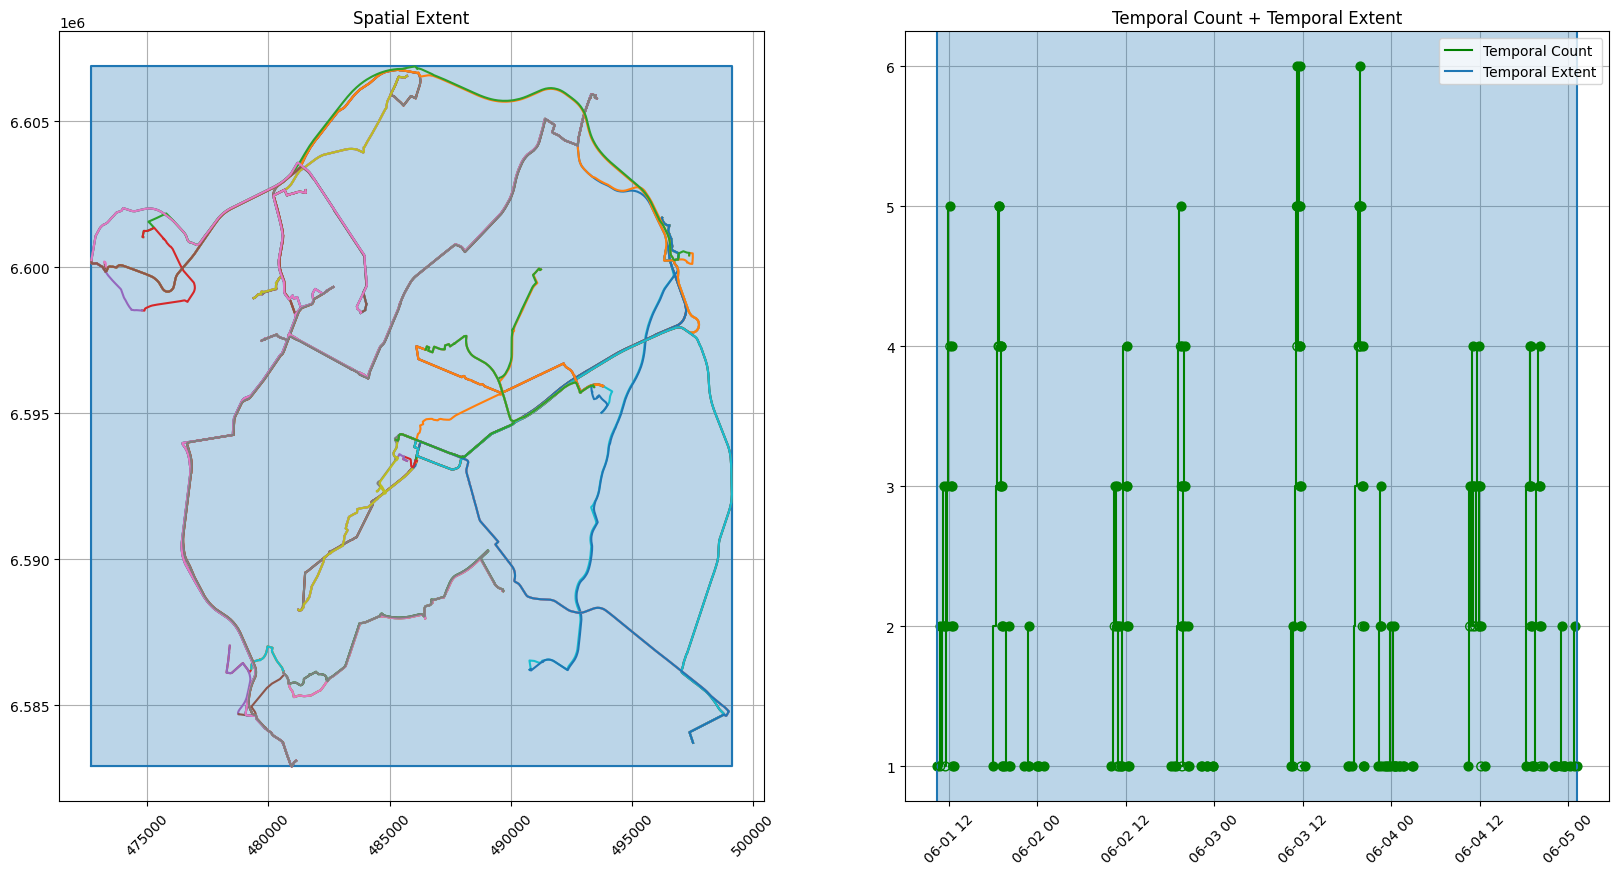

In [29]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))

extent_stream.plot_xy(axes=axes[0], label="Spatial Extent")
for _, trip in trips.iterrows():
    trip["trip"].plot(axes=axes[0], show_markers=False)
axes[0].set_title("Spatial Extent")

count_stream.plot(axes=axes[1], label="Temporal Count", color="g")
extent_stream.to_period().plot(axes=axes[1], label="Temporal Extent")
axes[1].set_title("Temporal Count + Temporal Extent")

plt.legend()
plt.show()

Note that you can keep aggregating after getting the result.

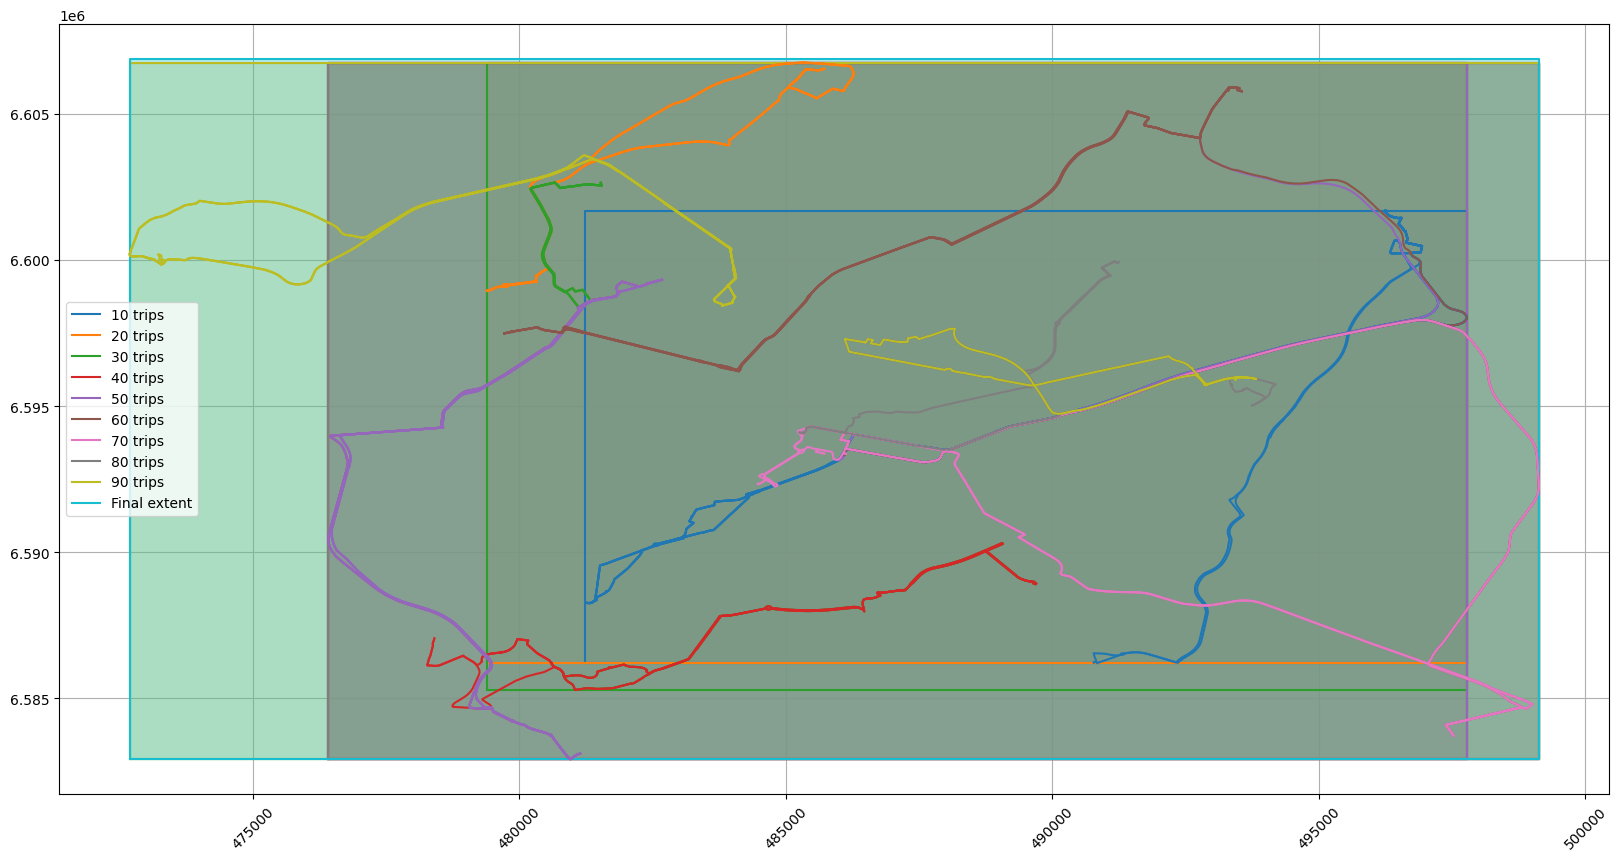

In [30]:
extent_aggregator = TemporalPointExtentAggregator.start_aggregation()
_, ax = plt.subplots(1, 1, figsize=(20, 10))
color = "black"
colors = []
for i, trip in enumerate(trips["trip"], 1):
    extent_aggregator.add(trip)
    if i % 10 == 0:
        plot = extent_aggregator.aggregation().plot_xy(label=f"{i} trips")
        color = plot[0][0].get_color()
        colors += [color] * 10
extent_stream = extent_aggregator.aggregation()
extent_stream.plot_xy(label="Final extent")

for trip, color in zip(trips["trip"], colors):
    trip.plot(show_markers=False, color=color)

plt.legend()
plt.show()

## Tiling Trips ([MEOS Example](https://libmeos.org/tutorialprograms/meos_tile_berlinmod/))

In this section, the trajectories and the speed will be split into tiles, for which we will compute some aggregates.

First, let's take a look at the tiled trajectories and speeds

In [31]:
tiled_trips = trips["trip"].apply(lambda tr: tr.tile(5e3, remove_empty=True))
speeds = trips["trip"].apply(lambda tr: tr.speed())
tiled_speeds = speeds.apply(
    lambda sp: sp.value_time_split(10, "1 day", 0, "2020-06-01")
)

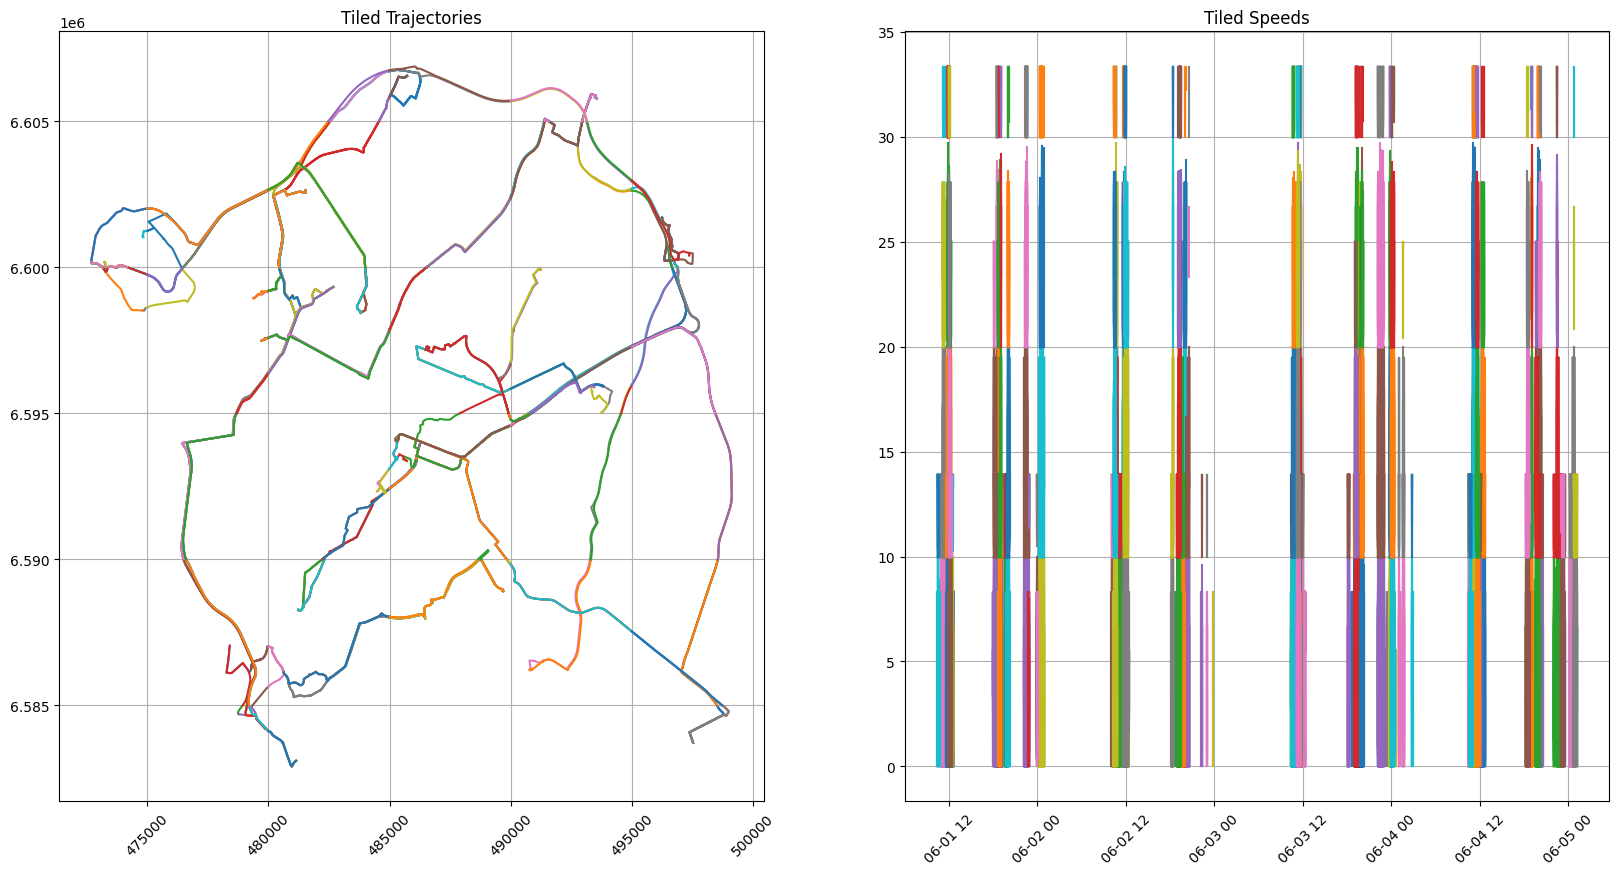

In [32]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))
for tiled_trip in tiled_trips:
    for traj in tiled_trip:
        traj.plot(axes=axes[0], show_markers=False)
axes[0].set_title("Tiled Trajectories")

for tiled_speed in tiled_speeds:
    for traj in tiled_speed:
        traj.plot(axes=axes[1], show_markers=False)
axes[1].set_title("Tiled Speeds")

plt.show()

To see the tiles more clearly, let's tile the extent of all the trips and speeds instead and compute the intersection of each trip with each tile (that is exactly what the `tile` function of TPointSeq is doing under the hood). This way, we can color them manually to see them clearly.

In [33]:
extent_tiles = extent_bulk.tile(5e3)
speed_extent = TemporalNumberExtentAggregator.aggregate(speeds)
speed_tiles = speed_extent.tile(10, "1 day", 0.0, "2020-06-01")

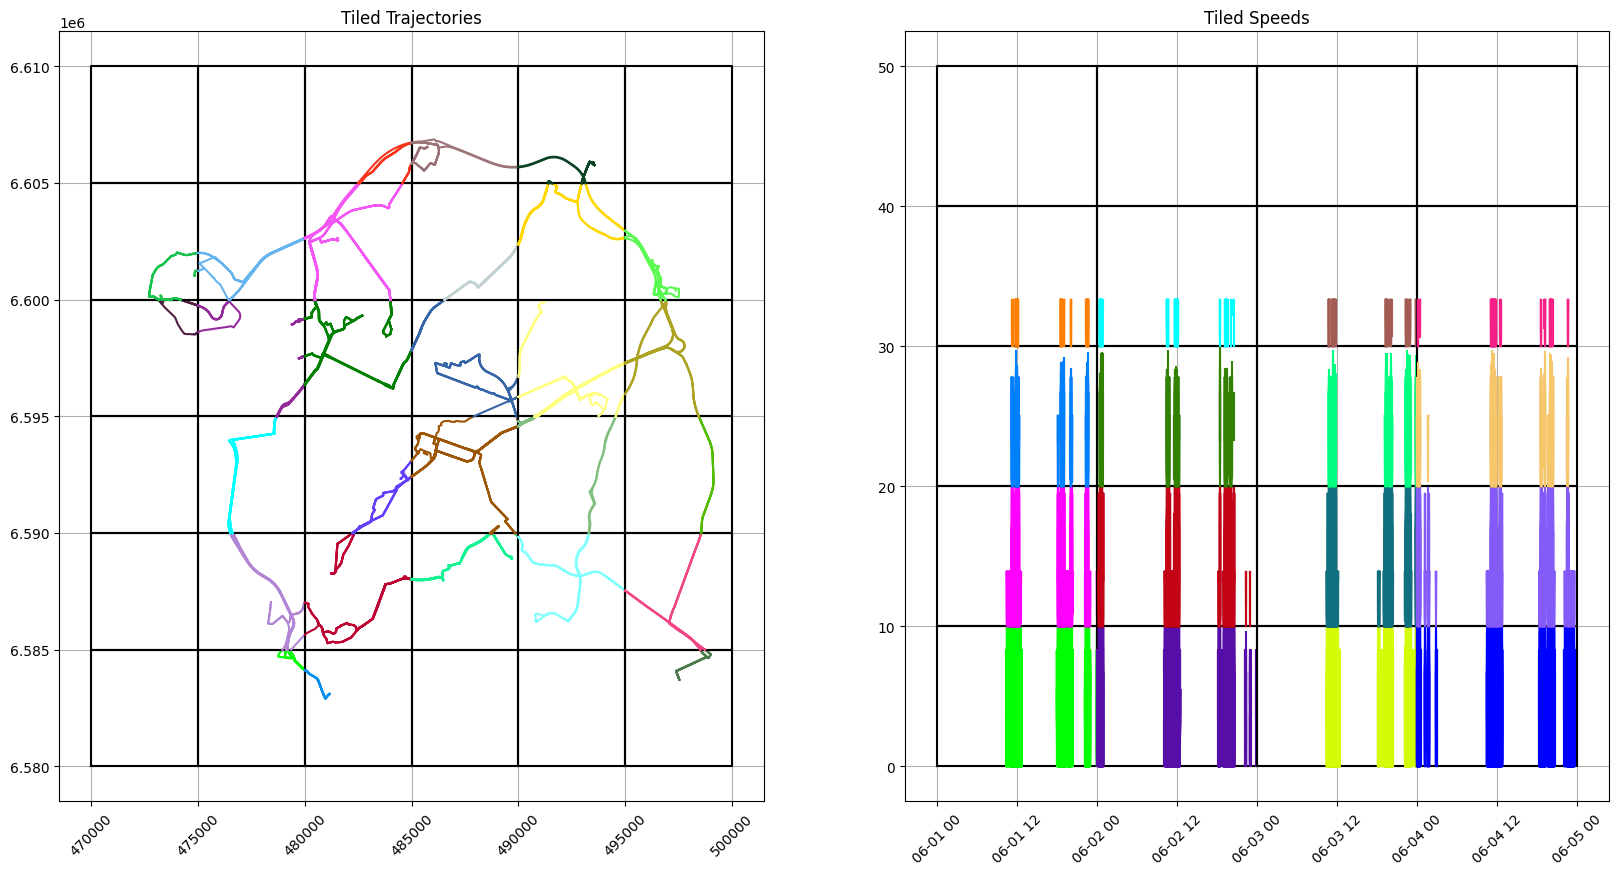

In [34]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))

for tile, color in zip(extent_tiles, distinctipy.get_colors(len(extent_tiles))):
    tile.plot_xy(axes=axes[0], color="black", draw_filling=False)
    for trip in trips["trip"]:
        trip_in_tile = trip.at(tile)
        if trip_in_tile is not None:
            trip_in_tile.plot(axes=axes[0], color=color, show_markers=False)
axes[0].set_title("Tiled Trajectories")

for tile, color in zip(speed_tiles, distinctipy.get_colors(len(speed_tiles))):
    tile.plot(axes=axes[1], color="black", draw_filling=False)
    for speed in speeds:
        speed_in_tile = speed.at(tile)
        if speed_in_tile is not None:
            speed_in_tile.plot(axes=axes[1], color=color, show_markers=False)
axes[1].set_title("Tiled Speeds")
plt.show()

Finally, let's aggregate the tiles to compute some metrics
We will start by computing, for each spatial tile, the number of trajectories that enter it, and the total amount of time spent and the total distance traveled by them in the tile.

In [35]:
extent_tiles = extent_bulk.tile(5e3)
data = []
for tile in extent_tiles:
    intersections = trips["trip"].apply(lambda tr: tr.at(tile)).dropna()
    if len(intersections) == 0:
        continue
    count = len(intersections)
    duration = sum([i.duration() for i in intersections], timedelta())
    distance = sum([i.length() for i in intersections]) / 1000
    data.append([tile, count, duration, distance])

spatial_aggregates = pd.DataFrame(
    data, columns=["tile", "count", "duration", "distance"]
)

In [36]:
spatial_aggregates

tile  count  \
0   SRID=3857;STBOX X((475000,6580000),(480000,658...     10   
1   SRID=3857;STBOX X((480000,6580000),(485000,658...      8   
2   SRID=3857;STBOX X((495000,6580000),(500000,658...      8   
3   SRID=3857;STBOX X((475000,6585000),(480000,659...     13   
4   SRID=3857;STBOX X((480000,6585000),(485000,659...     20   
5   SRID=3857;STBOX X((485000,6585000),(490000,659...     12   
6   SRID=3857;STBOX X((490000,6585000),(495000,659...      6   
7   SRID=3857;STBOX X((495000,6585000),(500000,659...      8   
8   SRID=3857;STBOX X((475000,6590000),(480000,659...      8   
9   SRID=3857;STBOX X((480000,6590000),(485000,659...     10   
10  SRID=3857;STBOX X((485000,6590000),(490000,659...     37   
11  SRID=3857;STBOX X((490000,6590000),(495000,659...     21   
12  SRID=3857;STBOX X((495000,6590000),(500000,659...      4   
13  SRID=3857;STBOX X((470000,6595000),(475000,660...      9   
14  SRID=3857;STBOX X((475000,6595000),(480000,660...     30   
15  SRID=3857;STBOX X((480000,6595000),(485000,660...     40   
16  SRID=3857;STBOX X((485000,6595000),(490000,660...     18   
17  SRID=3857;STBOX X((490000,6595000),(495000,660...     28   
18  SRID=3857;STBOX X((495000,6595000),(500000,660...     16   
19  SRID=3857;STBOX X((470000,6600000),(475000,660...     14   
20  SRID=3857;STBOX X((475000,6600000),(480000,660...     11   
21  SRID=3857;STBOX X((480000,6600000),(485000,660...     26   
22  SRID=3857;STBOX X((485000,6600000),(490000,660...      8   
23  SRID=3857;STBOX X((490000,6600000),(495000,660...     12   
24  SRID=3857;STBOX X((495000,6600000),(500000,660...     14   
25  SRID=3857;STBOX X((480000,6605000),(485000,661...     10   
26  SRID=3857;STBOX X((485000,6605000),(490000,661...     10   
27  SRID=3857;STBOX X((490000,6605000),(495000,661...     12   

                 duration    distance  
0  0 days 00:21:57.271928   12.715462  
1  0 days 00:37:50.260034   15.250435  
2  0 days 00:56:22.219006   19.807692  
3  0 days 01:42:26.592035   59.420951  
4  0 days 03:34:19.201837   73.582531  
5  0 days 02:07:10.468161   52.101740  
6  0 days 01:22:33.732748   36.422087  
7  0 days 00:47:50.956624   42.149632  
8  0 days 01:21:45.559201   54.962866  
9  0 days 01:39:18.880626   35.092058  
10 0 days 04:43:56.029545  135.629127  
11 0 days 01:08:30.026607   27.547398  
12 0 days 00:27:07.208503   20.924216  
13 0 days 00:16:51.436501   10.185846  
14 0 days 01:37:23.497930   38.060402  
15 0 days 05:02:47.976012  127.956860  
16 0 days 02:44:27.235479   69.741764  
17 0 days 03:01:46.069980  113.754468  
18 0 days 01:56:46.320943   79.532763  
19 0 days 01:08:43.444506   23.299969  
20 0 days 01:12:06.437047   55.651246  
21 0 days 04:36:55.024443  145.456576  
22 0 days 00:57:20.399942   36.388236  
23 0 days 01:54:33.371322   58.257905  
24 0 days 01:36:16.495602   46.346555  
25 0 days 00:40:21.652772   22.114868  
26 0 days 01:06:43.042539   33.102930  
27 0 days 00:41:57.630167   22.865846

For the speed tiles, we will compute the number of times a vehicle is in the speed range at that time, and the amount of time it stays there

In [37]:
speed_tiles = speed_extent.tile(10, "1 day", 0, "2020-06-01")
data = []
for tile in speed_tiles:
    intersections = speeds.apply(lambda tr: tr.at(tile)).dropna()
    if len(intersections) == 0:
        continue
    count = len(intersections)
    duration = sum([i.duration() for i in intersections], timedelta())
    data.append([tile, count, duration])

speed_aggregates = pd.DataFrame(data, columns=["tile", "count", "duration"])

In [38]:
speed_aggregates

tile  count  \
0   TBOXFLOAT XT([0, 10),[2020-06-01 00:00:00+02, ...     21   
1   TBOXFLOAT XT([10, 20),[2020-06-01 00:00:00+02,...     21   
2   TBOXFLOAT XT([20, 30),[2020-06-01 00:00:00+02,...     12   
3   TBOXFLOAT XT([30, 40),[2020-06-01 00:00:00+02,...     11   
4   TBOXFLOAT XT([0, 10),[2020-06-02 00:00:00+02, ...     23   
5   TBOXFLOAT XT([10, 20),[2020-06-02 00:00:00+02,...     21   
6   TBOXFLOAT XT([20, 30),[2020-06-02 00:00:00+02,...     12   
7   TBOXFLOAT XT([30, 40),[2020-06-02 00:00:00+02,...     11   
8   TBOXFLOAT XT([0, 10),[2020-06-03 00:00:00+02, ...     24   
9   TBOXFLOAT XT([10, 20),[2020-06-03 00:00:00+02,...     22   
10  TBOXFLOAT XT([20, 30),[2020-06-03 00:00:00+02,...     13   
11  TBOXFLOAT XT([30, 40),[2020-06-03 00:00:00+02,...     12   
12  TBOXFLOAT XT([0, 10),[2020-06-04 00:00:00+02, ...     28   
13  TBOXFLOAT XT([10, 20),[2020-06-04 00:00:00+02,...     26   
14  TBOXFLOAT XT([20, 30),[2020-06-04 00:00:00+02,...     14   
15  TBOXFLOAT XT([30, 40),[2020-06-04 00:00:00+02,...     12   

                 duration  
0  0 days 07:31:24.685901  
1  0 days 03:03:36.408255  
2  0 days 00:31:46.326571  
3  0 days 00:12:42.223983  
4  0 days 07:39:36.356752  
5  0 days 03:02:29.137009  
6  0 days 00:31:04.548691  
7  0 days 00:14:00.514541  
8  0 days 08:16:09.948028  
9  0 days 03:03:03.718551  
10 0 days 00:44:43.354712  
11 0 days 00:12:20.122468  
12 0 days 09:01:32.980751  
13 0 days 03:23:41.826769  
14 0 days 00:38:43.298191  
15 0 days 00:10:49.332312